In [1]:
# Code that might generate warnings
# %%
import warnings
import datetime
import os
import math
import time
import pandas as pd
import numpy as np
import pickle
import progressbar
import joblib
from joblib import Parallel, delayed
import multiprocessing
from multiprocessing import Process, Pool, Manager

import itertools
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from scipy.stats import skew, kurtosis
from numpy.lib.stride_tricks import as_strided as stride
from geopy.distance import geodesic
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from math import sqrt
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression
from scipy.stats import mode
from statsmodels.tools.tools import add_constant
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings("ignore")  # Ignore all warnings

# 每一条轨迹长短不一，在轨迹内采用滑动窗口L1（即决定窗口）,步长为L2,划分为子轨迹，提取子轨迹的特征。
# 在子轨迹上训练模型，最后可以基于轨迹进行后处理
L1 = 5  # s 滑动窗口的长度，暂时依据是20年直接给的5s的数据
L2 = 1  # 滑动窗口的步长，假设1s内没有变化（主要原因是GPS数据是1s记录的）

locs = ['Hand', 'Bag', 'Hips', 'Torso']

loc = locs[0]  # 'Hand'
dataset = 'train'

label_map = {
    1: 'Stilling',
    2: 'Walking',
    3: 'Run',
    4: 'Bike',
    5: 'Car',
    6: 'Bus',
    7: 'Train',
    8: 'Subway'
}

filenames = {
    'train': {
        'Hand': {
            'Location': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Hand/Location.pkl',
            'Location_new': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Hand/Location_new.pkl',
            # 进行标签匹配后的数据，时间戳是1HZ的label数据
            'Mag': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Hand/Mag.pkl',
            'Gyr': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Hand/Gyr.pkl',
            'Acc': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Hand/Acc.pkl',
            'GPS': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Hand/GPS.pkl',
            'GPS_new': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Hand/GPS_new.pkl',
        },
        'Bag': {
            'Location': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Bag/Location.pkl',
            'Location_new': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Bag/Location_new.pkl',
            'Mag': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Bag/Mag.pkl',
            'Gyr': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Bag/Gyr.pkl',
            'Acc': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Bag/Acc.pkl',
            'GPS': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Bag/GPS.pkl',
            'GPS_new': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Bag/GPS_new.pkl',
        },
        'Hips': {
            'Location': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Hips/Location.pkl',
            'Location_new': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Hips/Location_new.pkl',
            'Mag': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Hips/Mag.pkl',
            'Gyr': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Hips/Gyr.pkl',
            'Acc': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Hips/Acc.pkl',
            'GPS': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Hips/GPS.pkl',
            'GPS_new': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Hips/GPS_new.pkl',
        },
        'Torso': {
            'Location': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Torso/Location.pkl',
            'Location_new': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Torso/Location_new.pkl',
            'Mag': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Torso/Mag.pkl',
            'Gyr': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Torso/Gyr.pkl',
            'Acc': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Torso/Acc.pkl',
            'GPS': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Torso/GPS.pkl',
            'GPS_new': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Torso/GPS_new.pkl',
        },
        'Label': '/DATA2/lvxiaoling/limengyuan/SHL2023/train/Label.pkl'
    },
    'valid': {
        'Hand': {
            'Location': '/DATA2/lvxiaoling/limengyuan/SHL2023/valid/Hand/Location.pkl',
            'Mag': '/DATA2/lvxiaoling/limengyuan/SHL2023/valid/Hand/Mag.pkl',
            'Gyr': '/DATA2/lvxiaoling/limengyuan/SHL2023/valid/Hand/Gyr.pkl',
            'Acc': '/DATA2/lvxiaoling/limengyuan/SHL2023/valid/Hand/Acc.pkl',
            'GPS': '/DATA2/lvxiaoling/limengyuan/SHL2023/valid/Hand/GPS.pkl',
        },
        'Bag': {
            'Location': '/DATA2/lvxiaoling/limengyuan/SHL2023/valid/Bag/Location.pkl',
            'Location_new': '/DATA2/lvxiaoling/limengyuan/SHL2023/valid/Bag/Location_new.pkl',
            'Mag': '/DATA2/lvxiaoling/limengyuan/SHL2023/valid/Bag/Mag.pkl',
            'Gyr': '/DATA2/lvxiaoling/limengyuan/SHL2023/valid/Bag/Gyr.pkl',
            'Acc': '/DATA2/lvxiaoling/limengyuan/SHL2023/valid/Bag/Acc.pkl',
            'GPS': '/DATA2/lvxiaoling/limengyuan/SHL2023/valid/Bag/GPS.pkl',
            'GPS_new': '/DATA2/lvxiaoling/limengyuan/SHL2023/valid/Bag/GPS_new.pkl',
        },

        'Hips': {
            'Location': '/DATA2/lvxiaoling/limengyuan/SHL2023/valid/Hips/Location.pkl',
            'Location_new': '/DATA2/lvxiaoling/limengyuan/SHL2023/valid/Hips/Location_new.pkl',
            'Mag': '/DATA2/lvxiaoling/limengyuan/SHL2023/valid/Hips/Mag.pkl',
            'Gyr': '/DATA2/lvxiaoling/limengyuan/SHL2023/valid/Hips/Gyr.pkl',
            'Acc': '/DATA2/lvxiaoling/limengyuan/SHL2023/valid/Hips/Acc.pkl',
            'GPS': '/DATA2/lvxiaoling/limengyuan/SHL2023/valid/Hips/GPS.pkl',
            'GPS_new': '/DATA2/lvxiaoling/limengyuan/SHL2023/valid/Hips/GPS_new.pkl',
        },
        'Torso': {
            'Location': '/DATA2/lvxiaoling/limengyuan/SHL2023/valid/Torso/Location.pkl',
            'Location_new': '/DATA2/lvxiaoling/limengyuan/SHL2023/valid/Torso/Location_new.pkl',
            'Mag': '/DATA2/lvxiaoling/limengyuan/SHL2023/valid/Torso/Mag.pkl',
            'Gyr': '/DATA2/lvxiaoling/limengyuan/SHL2023/valid/Torso/Gyr.pkl',
            'Acc': '/DATA2/lvxiaoling/limengyuan/SHL2023/valid/Torso/Acc.pkl',
            'GPS': '/DATA2/lvxiaoling/limengyuan/SHL2023/valid/Torso/GPS.pkl',
            'GPS_new': '/DATA2/lvxiaoling/limengyuan/SHL2023/valid/Torso/GPS_new.pkl',
        },
        'Label': '/DATA2/lvxiaoling/limengyuan/SHL2023/valid/Label.pkl',
    },
    'test': {
        'Location': '/DATA2/lvxiaoling/limengyuan/SHL2023/test/Location.pkl',
        'Location_new': '/DATA2/lvxiaoling/limengyuan/SHL2023/test/Location_new.pkl',
        'Mag': '/DATA2/lvxiaoling/limengyuan/SHL2023/test/Mag.pkl',
        'Gyr': '/DATA2/lvxiaoling/limengyuan/SHL2023/test/Gyr.pkl',
        'Acc': '/DATA2/lvxiaoling/limengyuan/SHL2023/test/Acc.pkl',
        'GPS': '/DATA2/lvxiaoling/limengyuan/SHL2023/test/GPS.pkl',
        'GPS_new': '/DATA2/lvxiaoling/limengyuan/SHL2023/test/GPS_new.pkl',
        'Label': '/DATA2/lvxiaoling/limengyuan/SHL2023/test/Label.pkl'
    }
}


In [3]:
val_ml1 = pd.read_pickle('/DATA2/lvxiaoling/limengyuan/SHL2023/out_put2/val_ml1.pkl').reset_index(drop=True)
val_ml2 = pd.read_pickle('/DATA2/lvxiaoling/limengyuan/SHL2023/out_put2/val_ml2.pkl').reset_index(drop=True)
val_ml3 = pd.read_pickle('/DATA2/lvxiaoling/limengyuan/SHL2023/out_put2/val_ml3.pkl').reset_index(drop=True)
val_dl1 = pd.read_pickle('/DATA2/lvxiaoling/limengyuan/SHL2023/out_put2/val_dl1.pkl').reset_index(drop=True)
val_dl2 = pd.read_pickle('/DATA2/lvxiaoling/limengyuan/SHL2023/out_put2/val_dl2.pkl').reset_index(drop=True)

val_dl1 = val_dl1[val_dl1['idx'].isin(val_ml1['idx'])].reset_index(drop=True)
val_dl2 = val_dl2[val_dl2['idx'].isin(val_ml1['idx'])].reset_index(drop=True)

idx_equal = val_ml1['idx'].equals(val_ml2['idx']) and  val_ml1['idx'].equals(val_ml3['idx']) and val_ml1['idx'].equals(val_dl1['idx']) and  val_ml1['idx'].equals(val_dl2['idx']) 
idx_equal



True

In [4]:
cols = ['true','ml1','ml2','ml3','dl1','dl2']
df_val = pd.concat([val_ml1['label'],val_ml1['out_pred'],val_ml2['out_pred'],val_ml3['out_pred'],
               val_dl1['out_pred'],val_dl2['out_pred']],axis=1)
df_val.columns = cols
equal_ratio_matrix = pd.DataFrame(np.zeros((6, 6)), columns=cols, index=cols)

for col1 in cols:
    for col2 in cols:

        equal_ratio = accuracy_score(df_val[col1],df_val[col2])
        equal_ratio_matrix.loc[col1, col2] = equal_ratio
print('看一下验证集的预测结果相关性')
print(equal_ratio_matrix)



看一下验证集的预测结果相关性
          true       ml1       ml2       ml3       dl1       dl2
true  1.000000  0.800751  0.808009  0.796996  0.853426  0.861612
ml1   0.800751  1.000000  0.877168  0.895131  0.760609  0.756953
ml2   0.808009  0.877168  1.000000  0.866902  0.789801  0.768837
ml3   0.796996  0.895131  0.866902  1.000000  0.760309  0.751418
dl1   0.853426  0.760609  0.789801  0.760309  1.000000  0.864166
dl2   0.861612  0.756953  0.768837  0.751418  0.864166  1.000000


# 2.对out_probs 求平均(0.9597,后处理结果更好)

In [5]:
new_df = val_ml1[['out_{}'.format(i) for i in range(8)]] +\
        val_ml2[['out_{}'.format(i) for i in range(8)]] +\
        val_ml3[['out_{}'.format(i) for i in range(8)]] +\
        val_dl1[['out_{}'.format(i) for i in range(8)]] +\
        val_dl2[['out_{}'.format(i) for i in range(8)]] 

In [6]:
val_ml1

,label,label_idx,idx,timestamp,trajectory_id,out_0,out_1,out_2,out_3,out_4,out_5,out_6,out_7,out_pred
0,2.0,641,98052962,1497427497000,912,0.161567,0.147720,0.056574,0.088304,0.099579,0.364893,0.040614,0.040748,5.0
1,2.0,641,98053062,1497427498000,912,0.186343,0.161561,0.057857,0.059426,0.096546,0.332787,0.052653,0.052827,5.0
2,2.0,641,98053162,1497427499000,912,0.032171,0.129722,0.013423,0.013787,0.022398,0.764027,0.012215,0.012256,5.0
3,2.0,641,98053262,1497427500000,912,0.029956,0.044308,0.015844,0.228400,0.020856,0.637849,0.011374,0.011412,5.0
4,2.0,641,98053362,1497427501000,912,0.032485,0.437013,0.206437,0.141750,0.045487,0.081085,0.027825,0.027917,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143288,1.0,750,112447918,1497460755000,1044,0.548627,0.127262,0.026185,0.045223,0.037093,0.119204,0.026283,0.070122,0.0
143289,1.0,750,112448018,1497460756000,1044,0.611163,0.083681,0.029170,0.032197,0.034505,0.101890,0.029279,0.078115,0.0
143290,1.0,750,112448118,1497460757000,1044,0.639995,0.063574,0.028336,0.031277,0.033518,0.098977,0.028442,0.075882,0.0
143291,1.0,750,112448218,1497460758000,1044,0.653581,0.098553,0.028937,0.031941,0.034230,0.074041,0.029045,0.049672,0.0


In [7]:
mean_out_pred = new_df.idxmax(axis=1).str.replace('out_','').astype(int).values

In [8]:
accuracy = accuracy_score(val_ml1['label'], mean_out_pred)
print("Accuracy:", accuracy)
# 各个类别的预测准确率
report = classification_report(val_ml1[val_ml1['idx']>=98052438]['label'], mean_out_pred[val_ml1['idx']>=98052438])
print(report)
# 计算宏F1值
f1 = f1_score(val_ml1[val_ml1['idx']>=98052438]['label'], mean_out_pred[val_ml1['idx']>=98052438], average='macro')
print("F1 score:", f1)

Accuracy: 0.8830298758487853
              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94     29676
         1.0       0.97      0.94      0.95     25879
         2.0       0.99      0.86      0.92      2754
         3.0       1.00      0.71      0.83     12001
         4.0       0.97      0.54      0.69     20438
         5.0       0.43      0.94      0.59      9138
         6.0       0.97      0.99      0.98     21763
         7.0       0.94      0.99      0.97     21644

    accuracy                           0.88    143293
   macro avg       0.90      0.87      0.86    143293
weighted avg       0.92      0.88      0.89    143293

F1 score: 0.8604606422025305


## 2.1对所有out进行滑动平均

In [9]:
for k in [5,10,20,30,60,120,180,240,300,360,420,480,540,600,660,720]:
    print(k)
    new_pred = new_df.groupby(val_ml1['trajectory_id'])[['out_{}'.format(i) for i in range(8)]].rolling(k,center=True,min_periods=1).mean().reset_index()[['out_{}'.format(i) for i in range(8)]].idxmax(axis=1).str.replace('out_','').astype(int).values

    print('pred mode',f1_score(df_val['true'].values,new_pred, average='macro'))

5
pred mode 0.8644217560236013
10
pred mode 0.8679421716280016
20
pred mode 0.8730515212716652
30
pred mode 0.8750789757262971
60
pred mode 0.8795099658400163
120
pred mode 0.8877621137339655
180
pred mode 0.8890419752504668
240
pred mode 0.8913915200997016
300
pred mode 0.8938703566805594
360
pred mode 0.8967775287314452
420
pred mode 0.898019184522004
480
pred mode 0.8973734456013069
540
pred mode 0.8962935780940693
600
pred mode 0.8959993448072192
660
pred mode 0.8963530857997115
720
pred mode 0.8969644209413044


In [10]:
k=300
new_pred = new_df.groupby(val_ml1['trajectory_id'])[['out_{}'.format(i) for i in range(8)]].rolling(k,center=True,min_periods=1).mean().reset_index()[['out_{}'.format(i) for i in range(8)]].idxmax(axis=1).str.replace('out_','').astype(int).values


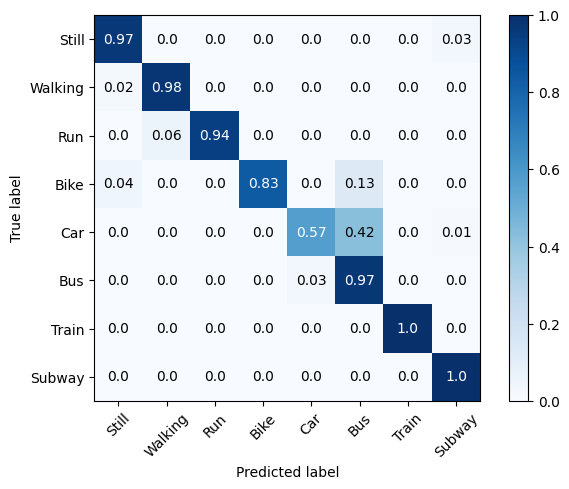

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 示例混淆矩阵
confusion_matrix_ = confusion_matrix(val_ml1['label'], new_pred,normalize='true')

# 类别标签
label_sort = ['Still','Walking','Run','Bike','Car','Bus','Train', 'Subway']

labels = label_sort

# 绘制混淆矩阵
plt.imshow(confusion_matrix_, cmap=plt.cm.Blues)
plt.colorbar()

# 设置刻度标签
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = confusion_matrix_.max() / 2
for i in range(confusion_matrix_.shape[0]):
    for j in range(confusion_matrix_.shape[1]):
        plt.text(j, i, '{}'.format(confusion_matrix_[i, j].round(2)),
                 ha="center", va="center",
                 color="white" if confusion_matrix_[i, j] > thresh else "black")

# 显示图形
plt.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
